<H1>Predicción de Ausencia de Paciente a su Cita Medica </H1>

<H2>Ejemplo de predicción con Logistic Regression y exportación a PMML</H2>

El ejemplo esta basado en 100 000 Citas medicas de una región (Vitória, Espírito Santo) de Brazil.
En base a caracteristicas demograficas, sociales y de enfermedades cronicas del paciente, se intenta determinar su presencia/ausencia en la cita programada.


Este ejemplo simple sirve para mostrar los aspectos siguientes
<ul>
    <li><em>Conexión desde Spark a la plataforma InterSystems IRIS</em<</li>
    <li><em>Acceso a un modelo de Datos Preparado para ML (Abstract Base Table)</em></li>
    <li><em>Entrenamiento de un algorithmo simple</em></li>
    <li><em>Exportación a PMML para la Operacionalización en InterSystems IRIS</em></li>
 </ul>


  Para mas claridad, este ejemplo ha sido reducido al maximo. No pretende enseñar mejores practicas de Python, ML, o estadisticas... Se pueden encontrar mas ejemplos y detalles de investigación sobre este mismo dataset en varios sitios, como por ejemplo:
  <ul>
    <li>[github](https://github.com/dovidburns/Doctor_Appointment_No_Shows)</li>
    <li>[kaggle](https://www.kaggle.com/somrikbanerjee/predicting-show-up-no-show)</li>
    <li>[Data Analytics and Modeling for Appointment No-show in Community Health Centers](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6243417/)</li>
    <li>[Designing risk prediction models for ambulatory no-shows across different specialties and clinics](https://academic.oup.com/jamia/article/25/8/924/4849782)</li>
 </ul>

<H2>Carga de Librerias Python</H2>

In [20]:
#Carga inicial de librerias imprescindibles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import seaborn as sns
#sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

#ML imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

#Pipeline needed for PMML Export
from sklearn.pipeline import Pipeline
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import make_pmml_pipeline
from sklearn2pmml import sklearn2pmml


from sklearn import metrics
from sklearn.metrics import roc_curve
#from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


In [2]:
#Verificación que pydpark este funcionando, para poder acceder a los datos en IRIS
import sys
print (sys.version)
sc

3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


<SparkContext master=local[*] appName=PySparkShell>

   ## Carga de los Datos Preparados usando el Intersystems IRIS Spark Connector
   
   Se accede a una projección de los datos (Abstract Base Table), con datos preparados para ML y columnas de categoria ya pre-expandidas en "One Hot Encoding" (Gender_F, Gener_M).
   Se ha reducido a proposito el numero de columnas proyectados aquí:
   <ul>
    <li>PublishedABT.MLSimpleAppointmentGetfeatures():  11 Columnas </li>
    <li>PublishedABT.MLAppointmentGetfeatures():       110 columnas </li>
   </ul>

In [3]:
#Carga del Modelo 'Abstract Base Table en un Spark DataFrame
sp_df=spark.read.format("com.intersystems.spark").\
option("url", "IRIS://127.0.0.1:51774/MLACADEMY").option("user", "_SYSTEM").\
option("password", "SYS").\
option("query", "PublishedABT.MLSimpleAppointmentsGetfeatures()").load() 

In [4]:
#Mostrar Informacion de filas & columnas
print((sp_df.count(), len(sp_df.columns)))

(110527, 11)


In [5]:
#Mostrar las columnas de caracteristicas y la columna de resultado (Classification == Presente/Ausente) 
#sp_df.columns
#sp_df.show(5)
sp_df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Alcoholism: boolean (nullable = true)
 |-- Delay: integer (nullable = true)
 |-- Diabetes: boolean (nullable = true)
 |-- Gender_F: integer (nullable = true)
 |-- Gender_M: integer (nullable = true)
 |-- Handicap: integer (nullable = true)
 |-- Hypertension: boolean (nullable = true)
 |-- Scholarship: boolean (nullable = true)
 |-- noShow: boolean (nullable = true)
 |-- smsReceived: boolean (nullable = true)



## Copia a un Pandas DataFrame

In [6]:
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
# Convert the Spark DataFrame back to a Pandas DataFrame using Arrow
# ((Nota: requiere fechas como TimeStamp (no funciona bien con Dates) ))
data = sp_df.select("*").toPandas()
# data.drop(['ID'],axis=1,inplace=True)  #Eliminamos las columnas de ID, no sirven para determinar el resultado

In [7]:
#Las primeras filas de datos
data.head()

,Age,Alcoholism,Delay,Diabetes,Gender_F,Gender_M,Handicap,Hypertension,Scholarship,noShow,smsReceived
0,13,False,7,False,0,1,0,False,False,False,False
1,62,False,0,False,1,0,0,True,False,False,False
2,48,False,11,False,1,0,0,False,False,True,False
3,56,False,0,False,0,1,0,False,False,False,False
4,43,False,10,False,1,0,0,False,False,False,False


In [8]:
#Y un recuento de los Nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 11 columns):
Age             110527 non-null int32
Alcoholism      110527 non-null bool
Delay           110527 non-null int32
Diabetes        110527 non-null bool
Gender_F        110527 non-null int32
Gender_M        110527 non-null int32
Handicap        110527 non-null int32
Hypertension    110527 non-null bool
Scholarship     110527 non-null bool
noShow          110527 non-null bool
smsReceived     110527 non-null bool
dtypes: bool(6), int32(5)
memory usage: 2.7 MB


<H1>Algoritmo ML de Logistic Regression</H1> 

es un algoritmo relativamente simple, y los resultados obtenidos sobre este conjunto de datos parcial (hemos limitado el numero de columnas para hacer algo mas simple en este tutorial) son "pasables". Aún así, nos permite ver como se genera el PMML y se pone en producción.

In [9]:
#Extracción de las Caracteristicas (en X) y del Resultado (columna "noShow" en y) como arrays numpy...
X = data.loc[:, ~data.columns.isin(['noShow'])].values
y = data.loc[:, 'noShow'].values

In [10]:
#Se separan los datos (110 000 filas) en 2 conjuntos: Train para entrenar,
# y test para validar los resultados del algoritmo
# 0.2 => 20% para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42) 

In [11]:
#Entrenamiento del Algoritmo Regresión Logistica, con "cross validation"
modelLR = LogisticRegressionCV(n_jobs=-1, cv=10, max_iter=200, scoring = 'f1')
modelLR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=200,
           multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring='f1', solver='lbfgs', tol=0.0001, verbose=0)

In [12]:
#Evaluación del modelo entrenado, sobre los datos de test
y_pred = modelLR.predict(X_test)

In [13]:
#Visualización de las metricas de Resultados
# Se han predecido casi ninguna ausencia con estos parametros del algorithmo (0.03)
print(metrics.f1_score(y_test, y_pred))

0.036755386565272496


In [14]:
# si bajamos el umbral de decision Show/noShow a una probabilidad de 0.32, obtenemos una mejora en el score f1...
y_pred_prob = modelLR.predict_proba(X_test)[:,1] >.32
print(metrics.f1_score(y_test, y_pred_prob))

0.19005989962765096


In [15]:
# La accuracy es mejorable....
# https://developers.google.com/machine-learning/crash-course/classification/accuracy
accuracy_score(y_test,y_pred_prob)

0.7736813534786936

In [16]:
# we have a decent somewhat poor AUC of 0.67
metrics.roc_auc_score(y_test,modelLR.predict_proba(X_test)[:,1])

0.6712802513064218

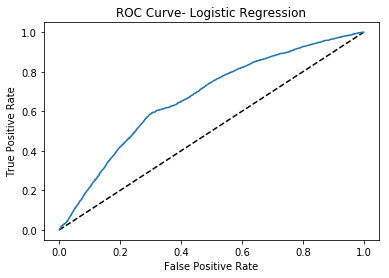

In [17]:
y_pred_prob = modelLR.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Regression')
plt.show()

<H1>Exportación a PMML</H1>

la exportación a PMML se puede hacer con sklearn2pmml y usa jpmml por debajo.
Es necesario definir un PMMLPipeline, al cual se podrían añadir etapas de pre-procesamiento que nio necesitamos aqui.
[Introducciçon sklearn2pmml](https://www.slideshare.net/VilluRuusmann/converting-scikitlearn-to-pmml)

In [18]:
#Extraimos los nombre de columnas de caracteristicas para añadirlas a la definición PMML
features=list(data.columns)
features.remove('noShow')
#print(len(features))

In [21]:
#Se crea el Pipelinne
myPipeline=Pipeline([('LogisticRegression',modelLR)])
myPMMLPipeline=make_pmml_pipeline(myPipeline,active_fields=features,target_fields=["noShow"])

In [23]:
sklearn2pmml(myPMMLPipeline, pmml="c:/users/pyd/MLAcademy.SimpleLR.pmml")

<H1> Pruebas de Validación </H1>

In [27]:
#Predicción sobre la primera fila
print(modelLR.predict_proba(X[1].reshape(1,-1)))

[[0.86937399 0.13062601]]


In [31]:
#Predicción sobre los mismos datos que hemos enviado via REST
Z=np.array([53,0,181,0,0,1,0,1,1,1]) #"Age":53 "Delay":181,"Diabetes":0,"Gender_F":0,"Gender_M":1,   "Handicap":0,    "Hypertension":1,"Scholarship":1,"smsReceived":1
print(modelLR.predict_proba(Z.reshape(1,-1)))

[[0.056492 0.943508]]
